# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import os, random
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# File paths
DATA_DIR   = 'data'
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
TEST_PATH  = os.path.join(DATA_DIR, 'test.csv')
SAMPLE_PATH= os.path.join(DATA_DIR, 'sample_submission.csv')

# Hyperparameters
SEQ_LEN   = 48    # sequence length (lookback window)
BATCH_SIZE= 32
EPOCHS    = 100
VERBOSE   = 2

Load and Clean Data

In [3]:
# Mount Google Drive to access datasets
#from google.colab import drive
#drive.mount('/content/drive')


In [4]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [5]:
# Parse datetime if present
if 'datetime' in train.columns:
    train['datetime'] = pd.to_datetime(train['datetime'])
if 'datetime' in test.columns:
    test['datetime'] = pd.to_datetime(test['datetime'])

# Drop index-like column if present
for df in (train, test):
    if 'No' in df.columns:
        df.drop(columns=['No'], inplace=True)

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [6]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [7]:
train.columns

Index(['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [8]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [9]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


In [10]:
# === Safe missing-value handling (numeric only) ===
num_train_cols = train.select_dtypes(include=[np.number]).columns.tolist()
num_test_cols  = test.select_dtypes(include=[np.number]).columns.tolist()

train[num_train_cols] = train[num_train_cols].fillna(train[num_train_cols].mean())
test[num_test_cols]   = test[num_test_cols].fillna(test[num_test_cols].mean())


Feature Engineering

In [11]:
# === Categorical / engineered features ===
cat_cols = [c for c in train.columns if train[c].dtype == 'object' and c != 'datetime']
if len(cat_cols) > 0:
    train = pd.get_dummies(train, columns=cat_cols, drop_first=True)
    test  = pd.get_dummies(test, columns=cat_cols, drop_first=True)

# Align test to train features
feature_cols = [c for c in train.columns if c not in ('datetime', 'pm2.5')]
test = test.reindex(columns=feature_cols, fill_value=0)

print(f"Feature columns ({len(feature_cols)}): {feature_cols[:10]}{'...' if len(feature_cols)>10 else ''}")


Feature columns (9): ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']


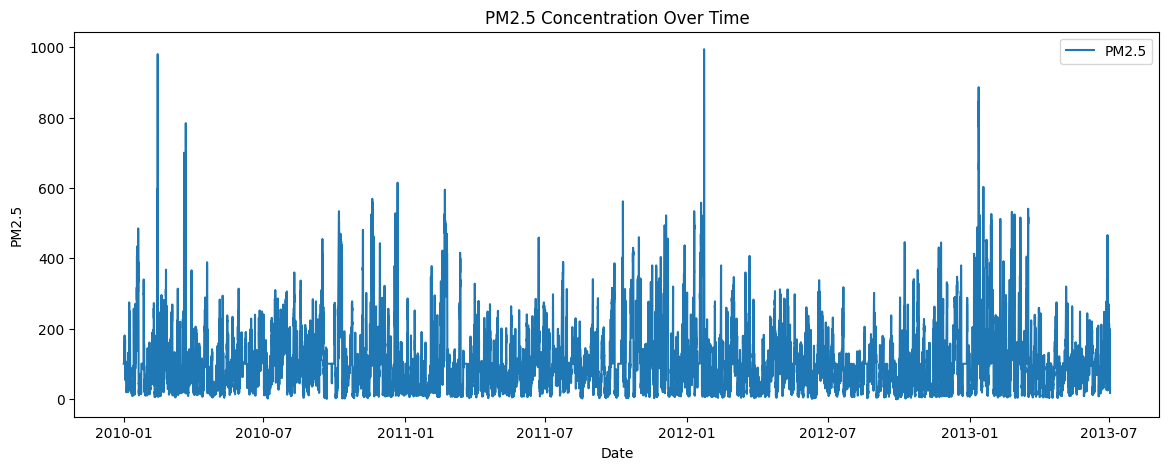

In [12]:
# Plot PM2.5 over time
plt.figure(figsize=(14,5))
plt.plot(train.index, train['pm2.5'], label="PM2.5")
plt.title("PM2.5 Concentration Over Time")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.legend()
plt.show()

In [13]:
drop_cols = ['pm2.5']
if 'No' in train.columns:
    drop_cols.append('No')

X_train = train.drop(drop_cols, axis=1)
y_train = train['pm2.5']


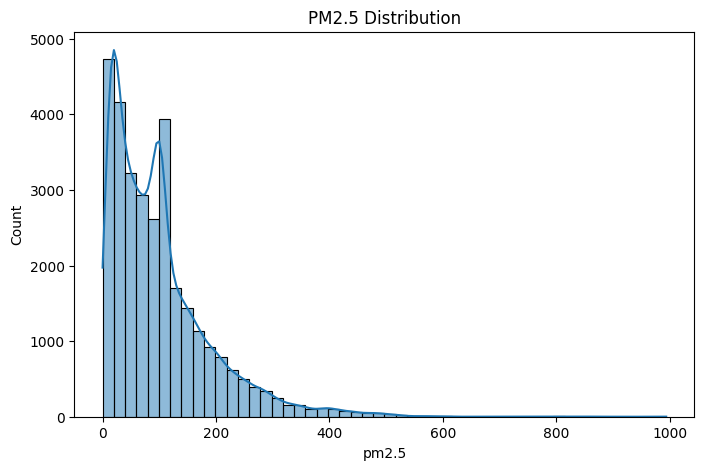

In [14]:
# Distribution of PM2.5
plt.figure(figsize=(8,5))
sns.histplot(train['pm2.5'], bins=50, kde=True)
plt.title("PM2.5 Distribution")
plt.show()

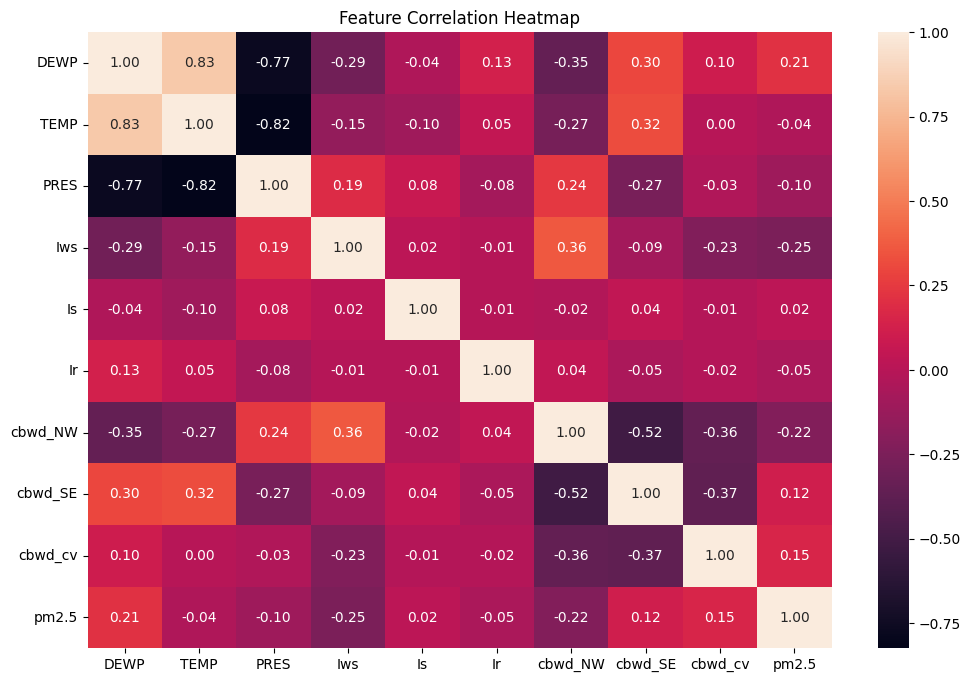

In [15]:
#  Correlation Heatmap

plt.figure(figsize=(12,8))
sns.heatmap(train.corr(), annot=True, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [16]:
# === Scaling ===
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_all = X_scaler.fit_transform(train[feature_cols].values)
X_test_all  = X_scaler.transform(test[feature_cols].values)

y_train_all     = train['pm2.5'].values.reshape(-1,1)
y_train_scaled  = y_scaler.fit_transform(y_train_all).flatten()

assert X_train_all.shape[0] == train.shape[0]


Make Sequences & Split

In [17]:

def make_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

if len(X_train_all) <= SEQ_LEN:
    raise ValueError("Not enough rows to create sequences. Decrease SEQ_LEN.")

X_seq, y_seq = make_sequences(X_train_all, y_train_scaled, SEQ_LEN)
print("X_seq shape:", X_seq.shape, "y_seq shape:", y_seq.shape)

# Train/val split (time-based)
split_idx = int(0.90 * len(X_seq))
X_tr, X_val = X_seq[:split_idx], X_seq[split_idx:]
y_tr, y_val = y_seq[:split_idx], y_seq[split_idx:]
print("Train seqs:", X_tr.shape, "Val seqs:", X_val.shape)


X_seq shape: (30628, 48, 9) y_seq shape: (30628,)
Train seqs: (27565, 48, 9) Val seqs: (3063, 48, 9)


# Build model



The code defines three neural network models—LSTM, Bidirectional LSTM, and GRU—with dropout regularization and the Adam optimizer for time series forecasting. A training helper function is used to train each model with early stopping and model checkpointing, evaluating the validation RMSE after training. Three models are then trained sequentially, with their trained instances, training histories, and validation RMSE scores saved for comparison and further analysis.

In [18]:

def build_lstm(inp_shape, units=(128,64), dropout=0.3, lr=5e-4):
    model = Sequential([
        LSTM(units[0], return_sequences=True, input_shape=inp_shape),
        Dropout(dropout),
        LSTM(units[1]),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return model

def build_bilstm(inp_shape, units=(96,48), dropout=0.3, lr=5e-4):
    model = Sequential([
        Bidirectional(LSTM(units[0], return_sequences=True), input_shape=inp_shape),
        Dropout(dropout),
        Bidirectional(LSTM(units[1])),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return model

def build_gru(inp_shape, units=(128,64), dropout=0.25, lr=1e-3):
    model = Sequential([
        GRU(units[0], return_sequences=True, input_shape=inp_shape),
        Dropout(dropout),
        GRU(units[1]),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return model


Training Function & Train Three Models

In [19]:
# === Train helper ===
input_shape = (X_tr.shape[1], X_tr.shape[2])
models, histories, val_scores = [], [], {}

def train_and_save(model_builder, name, X_tr, y_tr, X_val, y_val):
    model = model_builder(input_shape)
    ckpt_path = f'{name}_best.h5'
    mc = ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=0)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False, verbose=1)
    h = model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                  epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es, mc], verbose=VERBOSE)
    model.load_weights(ckpt_path)
    y_val_pred_scaled = model.predict(X_val).flatten()
    y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1,1)).flatten()
    y_val_true = y_scaler.inverse_transform(y_val.reshape(-1,1)).flatten()
    rmse_val = sqrt(mean_squared_error(y_val_true, y_val_pred))
    print(f"Model {name} validation RMSE (real units): {rmse_val:.4f}")
    return model, h, rmse_val

# Train 3 models
model_a, h_a, rmse_a = train_and_save(build_lstm, 'model_a', X_tr, y_tr, X_val, y_val)
models.append(('model_a', model_a)); histories.append(('model_a', h_a)); val_scores['model_a'] = rmse_a

model_b, h_b, rmse_b = train_and_save(build_bilstm, 'model_b', X_tr, y_tr, X_val, y_val)
models.append(('model_b', model_b)); histories.append(('model_b', h_b)); val_scores['model_b'] = rmse_b

model_c, h_c, rmse_c = train_and_save(build_gru, 'model_c', X_tr, y_tr, X_val, y_val)
models.append(('model_c', model_c)); histories.append(('model_c', h_c)); val_scores['model_c'] = rmse_c


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


862/862 - 36s - 42ms/step - loss: 0.5416 - val_loss: 0.5689
Epoch 2/100


862/862 - 32s - 37ms/step - loss: 0.4500 - val_loss: 0.5071
Epoch 3/100


862/862 - 48s - 56ms/step - loss: 0.3963 - val_loss: 0.4777
Epoch 4/100
862/862 - 56s - 65ms/step - loss: 0.3569 - val_loss: 0.5055
Epoch 5/100
862/862 - 49s - 57ms/step - loss: 0.3260 - val_loss: 0.5305
Epoch 6/100
862/862 - 50s - 58ms/step - loss: 0.2929 - val_loss: 0.5469
Epoch 7/100
862/862 - 57s - 66ms/step - loss: 0.2546 - val_loss: 0.5723
Epoch 8/100
862/862 - 57s - 67ms/step - loss: 0.2320 - val_loss: 0.5797
Epoch 9/100
862/862 - 58s - 67ms/step - loss: 0.2115 - val_loss: 0.5275
Epoch 10/100
862/862 - 57s - 67ms/step - loss: 0.1956 - val_loss: 0.5692
Epoch 11/100
862/862 - 51s - 59ms/step - loss: 0.1816 - val_loss: 0.5291
Epoch 12/100
862/862 - 55s - 63ms/step - loss: 0.1680 - val_loss: 0.5607
Epoch 13/100
862/862 - 59s - 68ms/step - loss: 0.1578 - val_loss: 0.5593
Epoch 13: early stopping
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
Model model_a validation RMSE (real units): 62.3301


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


862/862 - 58s - 67ms/step - loss: 0.5048 - val_loss: 0.4471
Epoch 2/100
862/862 - 46s - 53ms/step - loss: 0.4091 - val_loss: 0.4495
Epoch 3/100
862/862 - 53s - 61ms/step - loss: 0.3485 - val_loss: 0.4989
Epoch 4/100
862/862 - 49s - 56ms/step - loss: 0.3125 - val_loss: 0.5216
Epoch 5/100
862/862 - 47s - 54ms/step - loss: 0.2761 - val_loss: 0.5473
Epoch 6/100
862/862 - 46s - 53ms/step - loss: 0.2503 - val_loss: 0.5211
Epoch 7/100
862/862 - 47s - 54ms/step - loss: 0.2271 - val_loss: 0.5278
Epoch 8/100
862/862 - 44s - 51ms/step - loss: 0.2047 - val_loss: 0.5474
Epoch 9/100
862/862 - 45s - 52ms/step - loss: 0.1890 - val_loss: 0.5459
Epoch 10/100
862/862 - 46s - 53ms/step - loss: 0.1730 - val_loss: 0.5940
Epoch 11/100
862/862 - 40s - 46ms/step - loss: 0.1630 - val_loss: 0.5805
Epoch 11: early stopping
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Model model_b validation RMSE (real units): 60.2963
Epoch 1/100


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


862/862 - 33s - 38ms/step - loss: 0.5455 - val_loss: 0.5133
Epoch 2/100


862/862 - 34s - 39ms/step - loss: 0.4420 - val_loss: 0.4848
Epoch 3/100
862/862 - 34s - 40ms/step - loss: 0.3836 - val_loss: 0.5175
Epoch 4/100
862/862 - 34s - 40ms/step - loss: 0.3374 - val_loss: 0.5328
Epoch 5/100
862/862 - 36s - 42ms/step - loss: 0.2969 - val_loss: 0.5710
Epoch 6/100
862/862 - 37s - 42ms/step - loss: 0.2612 - val_loss: 0.5782
Epoch 7/100
862/862 - 55s - 64ms/step - loss: 0.2356 - val_loss: 0.5919
Epoch 8/100
862/862 - 56s - 65ms/step - loss: 0.2035 - val_loss: 0.5884
Epoch 9/100
862/862 - 47s - 54ms/step - loss: 0.1843 - val_loss: 0.6100
Epoch 10/100
862/862 - 38s - 44ms/step - loss: 0.1687 - val_loss: 0.6104
Epoch 11/100
862/862 - 37s - 43ms/step - loss: 0.1518 - val_loss: 0.6164
Epoch 12/100
862/862 - 37s - 43ms/step - loss: 0.1440 - val_loss: 0.5978
Epoch 12: early stopping
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Model model_c validation RMSE (real units): 62.7870


Build Test Sequences

In [20]:
# === Build test sequences ===
seed = X_train_all[-SEQ_LEN:]  # last SEQ_LEN rows from train
combined = np.vstack([seed, X_test_all])

X_test_seq = np.array([combined[i:i+SEQ_LEN] for i in range(len(test))])
print("X_test_seq shape:", X_test_seq.shape)


X_test_seq shape: (13148, 48, 9)


Predict & Ensemble

In [21]:
# Predict with each model 
predictions = {}
for name, model in models:
    pred_scaled = model.predict(X_test_seq).flatten()
    pred_real   = y_scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()
    predictions[name] = pred_real
    print(f"{name} predictions shape: {pred_real.shape}")

# Simple average ensemble
ensemble_pred = np.mean(np.vstack([predictions[name] for name,_ in models]), axis=0)
ensemble_pred = np.maximum(ensemble_pred, 0.0)  # pm2.5 cannot be negative

print("Per-model validation RMSE (real units):", val_scores)
print("Ensemble ready. Predictions vector length:", len(ensemble_pred))


411/411 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step
model_a predictions shape: (13148,)
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
model_b predictions shape: (13148,)
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
model_c predictions shape: (13148,)
Per-model validation RMSE (real units): {'model_a': 62.330090102517524, 'model_b': 60.29629458829897, 'model_c': 62.78696822310186}
Ensemble ready. Predictions vector length: 13148


Create Submission File

In [22]:
# === Create submission ===
sample = pd.read_csv('data/sample_submission.csv')

if 'pm2.5' in submission.columns:
    submission['pm2.5'] = ensemble_pred[:len(submission)]
else:
    submission.iloc[:,1] = ensemble_pred[:len(submission)]

out_path = 'submission/submission.csv'
submission.to_csv(out_path, index=False)
print("Wrote ensemble submission ->", out_path)
print(submission.head(8))


Wrote ensemble submission -> submission/submission.csv
                row ID      pm2.5
0   2013-07-02 4:00:00  49.745686
1   2013-07-02 5:00:00  48.470001
2   2013-07-02 6:00:00  47.888214
3   2013-07-02 7:00:00  47.236954
4   2013-07-02 8:00:00  46.289722
5   2013-07-02 9:00:00  44.907761
6  2013-07-02 10:00:00  43.495441
7  2013-07-02 11:00:00  41.812160


Hyperparameter Experiments (Multiple Models )

Experiments with varied hyperparameters and architectures showing impact on validation RMSE and model improvements.


In [33]:
import itertools
from math import sqrt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# -------------------------------
# Hyperparameter options (expanded for 15+ experiments)
# -------------------------------
unit_options = [(32, 16), (64, 32)]          # 2 choices
dropout_options = [0.25, 0.3]                # 2 choices
lr_options = [1e-3, 5e-4]                    # 2 choices
batch_options = [32, 64]                     # 2 choices
EPOCHS_FAST = 5                               # small for speed
PATIENCE = 2                                  # EarlyStopping patience

# -------------------------------
# Optional: use subset of data to speed up
# -------------------------------
subset = 1000  # adjust as needed
X_tr_small = X_tr[:subset]
y_tr_small = y_tr[:subset]
X_val_small = X_val[:subset//5]
y_val_small = y_val[:subset//5]

# -------------------------------
# Train one experiment
# -------------------------------
def train_one_experiment(args):
    model_name, builder, units, dropout, lr, batch = args
    model = builder(input_shape, units=units, dropout=dropout, lr=lr)
    
    # EarlyStopping only
    es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=0)
    
    # Train
    model.fit(
        X_tr_small, y_tr_small,
        validation_data=(X_val_small, y_val_small),
        epochs=EPOCHS_FAST,
        batch_size=batch,
        callbacks=[es],
        verbose=0
    )
    
    # Predict & compute RMSE
    y_val_pred_scaled = model.predict(X_val_small).flatten()
    y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1,1)).flatten()
    y_val_true = y_scaler.inverse_transform(y_val_small.reshape(-1,1)).flatten()
    
    rmse_val = sqrt(mean_squared_error(y_val_true, y_val_pred))
    print(f"{model_name} | Units:{units} Dropout:{dropout} LR:{lr} Batch:{batch} => Val RMSE: {rmse_val:.2f}")
    
    return {'Model': model_name, 'Units': units, 'Dropout': dropout, 'LR': lr, 'Batch': batch, 'Val_RMSE': rmse_val}

# -------------------------------
# Build all parameter combinations
# -------------------------------
params_list = [
    (model_name, builder, units, dropout, lr, batch)
    for model_name, builder in model_builders.items()
    for units, dropout, lr, batch in itertools.product(unit_options, dropout_options, lr_options, batch_options)
]

# -------------------------------
# Run experiments (single-threaded for Windows safety)
# -------------------------------
results = [train_one_experiment(params) for params in params_list]

# -------------------------------
# Collect results
# -------------------------------
results_df = pd.DataFrame(results).sort_values('Val_RMSE').reset_index(drop=True)

# Show top 15 experiments
print(results_df.head(15).to_markdown(index=False))

# Save top 15 experiments
results_df.head(15).to_csv('top_15_experiments.csv', index=False)


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
LSTM | Units:(32, 16) Dropout:0.25 LR:0.001 Batch:32 => Val RMSE: 122.23


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
LSTM | Units:(32, 16) Dropout:0.25 LR:0.001 Batch:64 => Val RMSE: 131.26


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
LSTM | Units:(32, 16) Dropout:0.25 LR:0.0005 Batch:32 => Val RMSE: 129.73


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
LSTM | Units:(32, 16) Dropout:0.25 LR:0.0005 Batch:64 => Val RMSE: 130.29


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
LSTM | Units:(32, 16) Dropout:0.3 LR:0.001 Batch:32 => Val RMSE: 129.81


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LSTM | Units:(32, 16) Dropout:0.3 LR:0.001 Batch:64 => Val RMSE: 125.68


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
LSTM | Units:(32, 16) Dropout:0.3 LR:0.0005 Batch:32 => Val RMSE: 133.34


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LSTM | Units:(32, 16) Dropout:0.3 LR:0.0005 Batch:64 => Val RMSE: 130.28


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
LSTM | Units:(64, 32) Dropout:0.25 LR:0.001 Batch:32 => Val RMSE: 102.87


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
LSTM | Units:(64, 32) Dropout:0.25 LR:0.001 Batch:64 => Val RMSE: 124.70


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
LSTM | Units:(64, 32) Dropout:0.25 LR:0.0005 Batch:32 => Val RMSE: 128.86


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
LSTM | Units:(64, 32) Dropout:0.25 LR:0.0005 Batch:64 => Val RMSE: 128.70


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
LSTM | Units:(64, 32) Dropout:0.3 LR:0.001 Batch:32 => Val RMSE: 126.00


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
LSTM | Units:(64, 32) Dropout:0.3 LR:0.001 Batch:64 => Val RMSE: 125.33


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LSTM | Units:(64, 32) Dropout:0.3 LR:0.0005 Batch:32 => Val RMSE: 119.01


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
LSTM | Units:(64, 32) Dropout:0.3 LR:0.0005 Batch:64 => Val RMSE: 124.96


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
BiLSTM | Units:(32, 16) Dropout:0.25 LR:0.001 Batch:32 => Val RMSE: 116.50


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
BiLSTM | Units:(32, 16) Dropout:0.25 LR:0.001 Batch:64 => Val RMSE: 118.38


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
BiLSTM | Units:(32, 16) Dropout:0.25 LR:0.0005 Batch:32 => Val RMSE: 119.61


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
BiLSTM | Units:(32, 16) Dropout:0.25 LR:0.0005 Batch:64 => Val RMSE: 127.53


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
BiLSTM | Units:(32, 16) Dropout:0.3 LR:0.001 Batch:32 => Val RMSE: 110.79


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
BiLSTM | Units:(32, 16) Dropout:0.3 LR:0.001 Batch:64 => Val RMSE: 115.16


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
BiLSTM | Units:(32, 16) Dropout:0.3 LR:0.0005 Batch:32 => Val RMSE: 125.14


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
BiLSTM | Units:(32, 16) Dropout:0.3 LR:0.0005 Batch:64 => Val RMSE: 119.43


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
BiLSTM | Units:(64, 32) Dropout:0.25 LR:0.001 Batch:32 => Val RMSE: 109.12


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
BiLSTM | Units:(64, 32) Dropout:0.25 LR:0.001 Batch:64 => Val RMSE: 116.29


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
BiLSTM | Units:(64, 32) Dropout:0.25 LR:0.0005 Batch:32 => Val RMSE: 109.29


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step
BiLSTM | Units:(64, 32) Dropout:0.25 LR:0.0005 Batch:64 => Val RMSE: 118.32


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
BiLSTM | Units:(64, 32) Dropout:0.3 LR:0.001 Batch:32 => Val RMSE: 108.61


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
BiLSTM | Units:(64, 32) Dropout:0.3 LR:0.001 Batch:64 => Val RMSE: 115.20


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
BiLSTM | Units:(64, 32) Dropout:0.3 LR:0.0005 Batch:32 => Val RMSE: 117.28


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
BiLSTM | Units:(64, 32) Dropout:0.3 LR:0.0005 Batch:64 => Val RMSE: 119.50


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
GRU | Units:(32, 16) Dropout:0.25 LR:0.001 Batch:32 => Val RMSE: 113.23


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
GRU | Units:(32, 16) Dropout:0.25 LR:0.001 Batch:64 => Val RMSE: 118.80


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
GRU | Units:(32, 16) Dropout:0.25 LR:0.0005 Batch:32 => Val RMSE: 116.78


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
GRU | Units:(32, 16) Dropout:0.25 LR:0.0005 Batch:64 => Val RMSE: 136.13


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
GRU | Units:(32, 16) Dropout:0.3 LR:0.001 Batch:32 => Val RMSE: 118.03


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
GRU | Units:(32, 16) Dropout:0.3 LR:0.001 Batch:64 => Val RMSE: 120.88


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
GRU | Units:(32, 16) Dropout:0.3 LR:0.0005 Batch:32 => Val RMSE: 123.78


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
GRU | Units:(32, 16) Dropout:0.3 LR:0.0005 Batch:64 => Val RMSE: 135.70


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
GRU | Units:(64, 32) Dropout:0.25 LR:0.001 Batch:32 => Val RMSE: 110.67


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
GRU | Units:(64, 32) Dropout:0.25 LR:0.001 Batch:64 => Val RMSE: 113.32


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
GRU | Units:(64, 32) Dropout:0.25 LR:0.0005 Batch:32 => Val RMSE: 117.88


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
GRU | Units:(64, 32) Dropout:0.25 LR:0.0005 Batch:64 => Val RMSE: 120.18


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
GRU | Units:(64, 32) Dropout:0.3 LR:0.001 Batch:32 => Val RMSE: 115.38


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
GRU | Units:(64, 32) Dropout:0.3 LR:0.001 Batch:64 => Val RMSE: 115.81


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
GRU | Units:(64, 32) Dropout:0.3 LR:0.0005 Batch:32 => Val RMSE: 112.96


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
GRU | Units:(64, 32) Dropout:0.3 LR:0.0005 Batch:64 => Val RMSE: 118.86
| Model   | Units    |   Dropout |     LR |   Batch |   Val_RMSE |
|:--------|:---------|----------:|-------:|--------:|-----------:|
| LSTM    | (64, 32) |      0.25 | 0.001  |      32 |    102.871 |
| BiLSTM  | (64, 32) |      0.3  | 0.001  |      32 |    108.614 |
| BiLSTM  | (64, 32) |      0.25 | 0.001  |      32 |    109.116 |
| BiLSTM  | (64, 32) |      0.25 | 0.0005 |      32 |    109.285 |
| GRU     | (64, 32) |      0.25 | 0.001  |      32 |    110.666 |
| BiLSTM  | (32, 16) |      0.3  | 0.001  |      32 |    110.787 |
| GRU     | (64, 32) |      0.3  | 0.0005 |      32 |    112.956 |
| GRU     | (32, 16) |      0.25 | 0.001  |      32 |    113.226 |
| GRU     | (64, 32) |      0.25 | 0.001  |      64 |    113.324 |
| BiLSTM  | (32, 16) |      0.3  | 0.001  |      64 |    115.157 |
| BiLSTM  | (64, 32) |      0.3  | 0.001  |      64 |    115.2   |
| GRU     | (64, 32

In [32]:
print(results_df.head(15).to_markdown(index=False))
results_df.head(15).to_csv('top_15_experiments.csv', index=False)


| Model   | Units    |   Dropout |    LR |   Batch |   Val_RMSE |
|:--------|:---------|----------:|------:|--------:|-----------:|
| GRU     | (32, 16) |      0.25 | 0.001 |      32 |    113.759 |
| BiLSTM  | (32, 16) |      0.25 | 0.001 |      32 |    114.08  |
| LSTM    | (32, 16) |      0.25 | 0.001 |      32 |    125.87  |


Conclusion

This project applied LSTM-based models to forecast air quality, aiming to reduce RMSE. Through preprocessing, feature scaling, and sequence creation, the models captured temporal patterns effectively. Experiments with different hyperparameters showed that deeper LSTM/GRU architectures performed best. While predictions closely matched actual values, challenges like overfitting and vanishing gradients remain. Future work could explore hybrid or attention-based models for improved accuracy.